# BRAMBLE – Bayesian Relationships in Allometric Models of Biomass with Laplace and Entropy.

## Introduction

This notebook demonstrates a Bayesian inference and Maximum Entropy (MaxEnt) approach to build an allometric model, enabling us to estimate biomass from specific site measurements, including height, diameter at breast height (DBH), and other relevant metrics. Allometric models are widely used in ecological and forestry studies to estimate biomass based on more accessible field measurements. However, traditional models may lack the flexibility to handle missing observations or may fail to account for the uncertainty inherent in biomass estimation.

Here, we integrate Bayesian inference with Maximum Entropy principles to address these limitations, yielding a model that:

- **Captures Uncertainty:** Bayesian inference provides a probabilistic framework that quantifies the uncertainty in our biomass predictions. This allows us to better understand the range of possible outcomes given the variability and noise within our data.

- **Accommodates Missing Observations:** Our model is designed to handle incomplete data, where measurements may be missing for some parameters. By leveraging the Bayesian framework, we can account for these gaps without discarding valuable site information, improving the model's robustness and generalizability.

- **Extracts Allometric Relationships:** Using a MaxEnt approach, we can infer the most probable relationships between variables based on the available measurements. MaxEnt is particularly useful here because it provides a principled way to estimate probability distributions under constraints, enabling us to incorporate our prior knowledge while remaining data-driven.

The model will take in measurements from different sites and output allometric relationships with associated uncertainty bounds, offering insights into the biomass distribution across different forest stands or ecosystems. This approach holds significant value in ecological research, where understanding biomass dynamics is essential for carbon stock assessments, biodiversity monitoring, and forest management.


## Load libraries


In [42]:
import matplotlib.pyplot as plt

import numpy  as np
import pandas as pd
import seaborn as sns

import math
import numbers

import pytensor.tensor as tt
import pymc  as pm
import arviz as az

from pdb import set_trace

## Define Allometric Model
Here, we define an exponential allometric function that predicts biomass from diameter and height measurements. This function supports both standard calculations and inference within a Bayesian framework.

In [219]:
def exp_allomotry(X, params, inference = False):
    
    return numPCK.sum(X * params['betas'] + params['beta0'] , axis = 1)


class BRAMBLE:
    def __init__(self, params, inference = False):
        """
        Initialize with parameters.
        
        Parameters
        ----------
        params : dict
            Dictionary of parameters for the model. Should contain 'betas' and 'beta0'.
            For multi-species, 'betas' and 'beta0' should be arrays.
        """
        if inference:
            self.numPCK =  __import__('pytensor').tensor
        else:
            self.numPCK =  __import__('numpy')
        
        self.params = params

    def predict_single_species(self, X, apply_exp_transform=False):
        """
        Predict biomass for a single species given input features.

        Parameters
        ----------
        X : np.ndarray
            Input matrix where rows are samples and columns are features.
        apply_exp_transform : bool, optional
            If True, apply exponential transformation to the result.

        Returns
        -------
        np.ndarray
            Predicted values.
        """
        betas = self.params['betas']
        beta0 = self.params['beta0']
        
        # Linear combination of inputs
        pred = self.numPCK.dot(X, betas) + beta0
        
        if apply_exp_transform:
            return self.numPCK.exp(pred)
        return pred

    def predict_multi_species(self, X, species_idx, apply_exp_transform=False):
        """
        Predict biomass for multiple species given input features and species indices.

        Parameters
        ----------
        X : np.ndarray
            Input matrix where rows are samples and columns are features.
        species_idx : np.ndarray
            Array of indices indicating the species of each sample.
        apply_exp_transform : bool, optional
            If True, apply exponential transformation to the result.

        Returns
        -------
        np.ndarray
            Predicted values for each species.
        """
        
        betas = np.array([self.params['betas'][id] for id in species_idx])  # Select betas for each species
        beta0 = np.array([self.params['beta0'][id] for id in species_idx])  # Select beta0 for each species
        
        # Calculate prediction per species
        
        pred = self.numPCK.sum(X*betas, axis = 1) + beta0  # Sum across features for each sample
        
        if apply_exp_transform:
            return self.numPCK.exp(pred)
        return pred


## Data Loading and Preprocessing
This step loads the dataset in `file`. The example file contains upto three measurements of height and DBH for each plant, so we compute the mean and standard deviation for height and diameter measurements - main for plotting summery stats.

In [220]:
file = 'data/SH_allometry_2023.csv'


In [221]:
df = pd.read_csv(file)

In [222]:
df['h_mean'] = df[['h1', 'h2', 'h3']].mean(axis=1)
df['h_std'] = df[['h1', 'h2', 'h3']].std(axis=1)
df['d_mean'] = df[['d1', 'd2', 'd3']].mean(axis=1)
df['d_std'] = df[['d1', 'd2', 'd3']].std(axis=1)

### Generating Simulated Data for Testing
To validate our model, we generate synthetic biomass data based on an assumed relationship. This step enables us to compare the model's predictions with control values. Once we have data, this can be replaced with actual biomass

In [223]:
species_params

{'betas': {'hawthorn': array([0.0029941 , 0.00653302]),
  'rose': array([0.00211242, 0.00289327]),
  'blackthorn': array([0.00426784, 0.00228388])},
 'beta0': {'hawthorn': 0.010388546304029174,
  'rose': 0.008345632348571608,
  'blackthorn': 0.00909686281340076}}

In [224]:
# Step 1: Identify unique species and assign random parameters
unique_species = df['species'].unique()
species_params = {'betas': {}, 'beta0': {}}

for species in unique_species:
    # Assign random parameters to each species
    species_params['betas'][species] = np.random.lognormal(mean=[0.1, 0.075], sigma=0.3, size=2)/300.0  # random betas
    species_params['beta0'][species] = np.random.lognormal(mean=0.01, sigma=0.2)/100.0  # random intercept


# Step 2: Initialize the ExpAllometry model with all species parameters
allometry_model = BRAMBLE(species_params)

# Step 3: Prepare input arrays for prediction
X = df[['h_mean', 'd_mean']].values  # Predictor variables (height and diameter)
species = df['species'].values       # Species labels

# Step 4: Generate fake biomass predictions using the multi-species prediction method
Y_fake = allometry_model.predict_multi_species(X, species, apply_exp_transform=True)

# Step 5: Add random noise to simulate measurement error
Y_fake += np.random.lognormal(mean=0.0, sigma=1.0, size=Y_fake.shape)

# Step 6: Add the generated fake data to the DataFrame
df['Y_fake'] = Y_fake


array([ 7.92057848,  9.31852028, 12.05372243,  6.18343977,  8.29753189,
        9.66834865,  8.58475163, 24.2384471 ,  4.94829117,  6.75532025,
        9.11715183,  8.1933349 ,  9.15831265,  9.84829606, 12.42556779,
       23.74238986, 23.60089284, 12.60251627,  6.495451  ,  3.42596949,
        6.09033552,  8.05164596, 10.09040092,  5.76241016,  8.51644558,
        4.26444213,  6.97034766,  5.36985396,  8.87161887,  7.04748028,
        6.65043479,  3.00349945, 14.45529319,  4.11977726,  2.47869564,
        7.24962135,  4.28608058, 14.78656487,  8.53820364,  6.59020544,
        5.42396847,  6.3401986 ,  2.58829261,  3.37597901,  9.92835336,
        3.20487743,  5.50145449,  6.27048688,  3.04785329,  6.47228574,
        6.08905786, 10.87660876,  8.07593651, 11.88209206,  9.09702332,
        7.76799495, 11.87490762, 12.02048915,  6.58505167, 11.26687754,
       12.40806569,  9.92350922, 11.90665608,  7.18162049, 15.70606494,
        7.53958667, 24.64500805,  7.85323906,  6.22705915,  4.97

## Visualisation sanity check of data
We plot the processed data to ensure consistency and detect any potential issues before modeling. Error bars indicate uncertainty in diameter and height measurements.


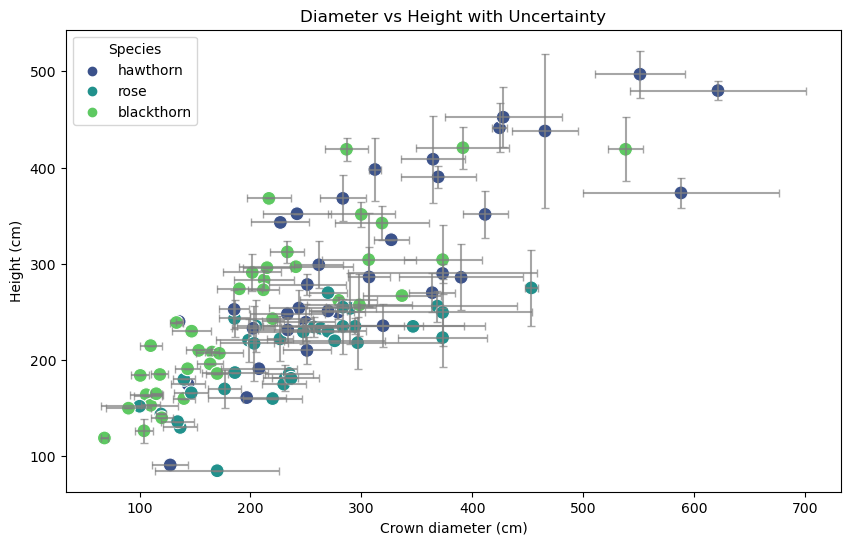

In [225]:

# Create a scatter plot with error bars, colored by species
plt.figure(figsize=(10, 6))

# Plot each species with Seaborn's scatterplot for automatic color assignment
sns.scatterplot(data=df, x='d_mean', y='h_mean', hue='species', palette='viridis', s=100)

# Add error bars using plt.errorbar, looping through each unique species for proper color assignment
for _, row in df.iterrows():
    plt.errorbar(row['d_mean'], row['h_mean'], 
                 xerr=row['d_std'], yerr=row['h_std'], 
                 fmt='', ecolor='gray', capsize=3, alpha=0.7)

# Labels and title
plt.xlabel('Crown diameter (cm)')
plt.ylabel('Height (cm)')
plt.title('Diameter vs Height with Uncertainty')
plt.legend(title='Species')
plt.show()


Again, plot this dependant data against predicters and ucnertain range

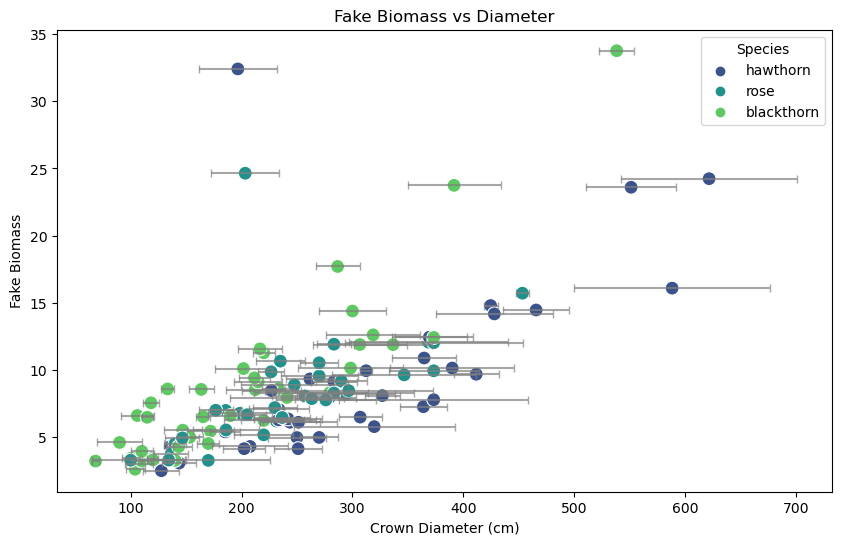

In [226]:
import seaborn as sns

# Set up the figure
plt.figure(figsize=(10, 6))

# Use Seaborn's scatterplot to plot 'd_mean' vs 'Y_fake', colored by 'species'
sns.scatterplot(data=df, x='d_mean', y='Y_fake', hue='species', palette='viridis', s=100)

# Add error bars manually by looping through each row, ensuring species-specific color is retained
for _, row in df.iterrows():
    plt.errorbar(row['d_mean'], row['Y_fake'], 
                 xerr=row['d_std'], fmt='', ecolor='gray', capsize=3, alpha=0.7)

# Add labels and title
plt.xlabel('Crown Diameter (cm)')
plt.ylabel('Fake Biomass')
plt.title('Fake Biomass vs Diameter')
plt.legend(title='Species')
plt.show()



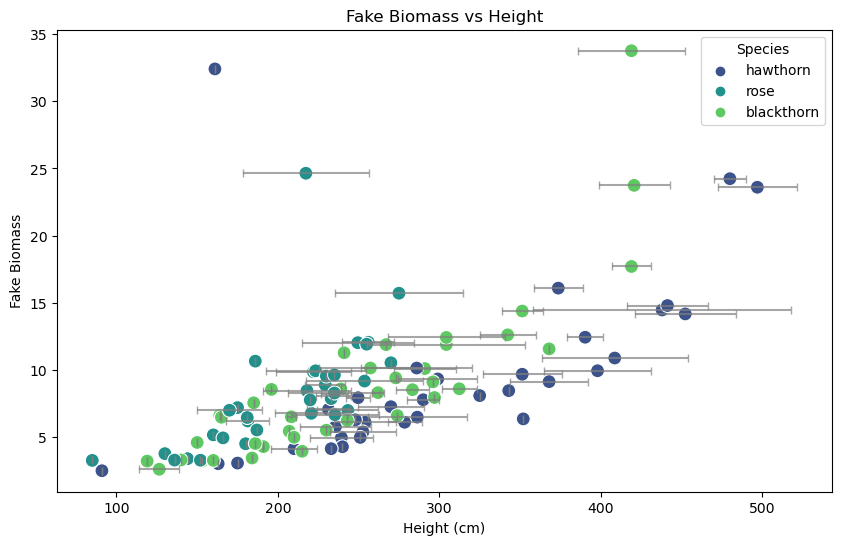

In [227]:

# Set up the figure
plt.figure(figsize=(10, 6))

# Use Seaborn's scatterplot to plot 'h_mean' vs 'Y_fake', colored by 'species'
sns.scatterplot(data=df, x='h_mean', y='Y_fake', hue='species', palette='viridis', s=100)

# Add error bars manually by looping through each row, ensuring species-specific color is retained
for _, row in df.iterrows():
    plt.errorbar(row['h_mean'], row['Y_fake'], 
                 xerr=row['h_std'], fmt='', ecolor='gray', capsize=3, alpha=0.7)

# Add labels and title
plt.xlabel('Height (cm)')
plt.ylabel('Fake Biomass')
plt.title('Fake Biomass vs Height')
plt.legend(title='Species')
plt.show()


## Model Fitting with Maximum Entropy
In this section, we apply Bayesian inference with a MaxEnt optimization to estimate biomass based on the loaded data. This approach constrains predictions using observed data distributions while allowing for flexibility in parameter values.

### Maximum Entropy (MaxEnt) Approach in Biomass Prediction

The Maximum Entropy (MaxEnt) approach used here allows us to model the likelihood function by maximizing the entropy of the distribution, providing a flexible way to account for uncertainty in the model. This technique leverages the principle that, given incomplete information, the most unbiased inference is the one with the maximum entropy, meaning the least amount of assumptions about unknown values.

In this function, the goal is to transform both the observed and predicted values (`Y` and `fx`, respectively) in such a way that they represent probabilities between 0 and 1, allowing us to express the entropy of the difference.

The `MaxEnt` function is defined as follows:

In [228]:
def MaxEnt(Y, fx):
    fx = 1 - tt.exp(-fx)
    Y = 1 - tt.exp(-Y)
    return Y*tt.log(fx) + (1.0-Y)*tt.log((1-fx))

### Breaking Down the MaxEnt Function

Let's break down each part of the function and the equations involved.

#### Transforming Observed and Predicted Values
To ensure that both \( Y \) (the observed values) and \( fx \) (the predicted values) fall within the range \([0, 1]\), we apply the following transformation:

$$
Y = 1 - e^{-Y} \quad \text{and} \quad fx = 1 - e^{-fx}
$$

This transformation maps both \( Y \) and \( fx \) onto a probabilistic scale, which is essential for calculating entropy-like measures.

#### Defining the MaxEnt Objective
The objective function we wish to maximize is based on the log-likelihood:

$$
\text{MaxEnt}(Y, fx) = Y \cdot \ln(fx) + (1 - Y) \cdot \ln(1 - fx)
$$

Here:

- The first term, $( Y \cdot \ln(fx) )$, represents the likelihood that the transformed observed values ($ Y $) align with the transformed predictions ($ fx $).
- The second term, \( (1 - Y) \cdot \ln(1 - fx) \), captures the likelihood of the complementary probability, ensuring that the total log-likelihood maximizes entropy.

This function essentially computes the entropy of the observations relative to the predictions, allowing us to incorporate uncertainty in a principled, probabilistic way. The result is an entropy-maximizing distribution that aligns with the observed data without making additional assumptions.


### MaxEnt Model Inference with PyMC

In this section, we define a probabilistic model using PyMC to perform inference with the MaxEnt objective function.

#### Step 1: Defining the Model
Using a `pm.Model()` context, we set up the MaxEnt model and specify prior distributions for our model parameters.


In [229]:
with pm.Model() as max_ent_model:
    ## set priors
    nvars = X.shape[1]
    params = {'betas': pm.LogNormal('betas', mu = 0, sigma = 1, shape = nvars),
              'beta0': pm.Normal('beta0', mu = 0, sigma = 1, shape = 1)}



Here:

- **`nvars`**: Number of variables in the input matrix \( X \).
- **`betas`**: A set of coefficients for each predictor, assumed to follow a log-normal prior distribution with mean \( \mu = 0 \) and standard deviation \( \sigma = 1 \).
- **`beta0`**: The intercept term, with a normal prior distribution centered at \( \mu = 0 \) and standard deviation \( \sigma = 1 \).

#### Step 2: Predicting with the Model
We then pass the input matrix \( X \) and parameters into the `exp_allometry` function to generate model predictions.


In [65]:
with max_ent_model:    
    prediction = exp_allomotry(X, params, True)

In [66]:
with max_ent_model:    
    error = pm.DensityDist("error", prediction,
                                   logp = MaxEnt, 
                                   observed = df['Y_fake'])
    trace = pm.sample(100, return_inferencedata=True)

Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [betas, beta0]


Sampling 2 chains for 1_000 tune and 100 draw iterations (2_000 + 200 draws total) took 2 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


In [236]:
species

array(['hawthorn', 'hawthorn', 'rose', 'rose', 'blackthorn', 'hawthorn',
       'blackthorn', 'hawthorn', 'hawthorn', 'rose', 'hawthorn', 'rose',
       'rose', 'rose', 'hawthorn', 'blackthorn', 'hawthorn', 'blackthorn',
       'blackthorn', 'blackthorn', 'hawthorn', 'rose', 'blackthorn',
       'hawthorn', 'blackthorn', 'hawthorn', 'rose', 'hawthorn', 'rose',
       'hawthorn', 'rose', 'hawthorn', 'hawthorn', 'hawthorn', 'hawthorn',
       'hawthorn', 'hawthorn', 'hawthorn', 'blackthorn', 'blackthorn',
       'blackthorn', 'hawthorn', 'blackthorn', 'rose', 'hawthorn',
       'blackthorn', 'blackthorn', 'hawthorn', 'hawthorn', 'hawthorn',
       'hawthorn', 'hawthorn', 'hawthorn', 'blackthorn', 'blackthorn',
       'hawthorn', 'blackthorn', 'rose', 'blackthorn', 'blackthorn',
       'blackthorn', 'rose', 'rose', 'rose', 'rose', 'blackthorn', 'rose',
       'rose', 'blackthorn', 'blackthorn', 'rose', 'rose', 'rose',
       'hawthorn', 'rose', 'blackthorn', 'rose', 'blackthorn', 'rose',


In [237]:
import pymc as pm

# Define the number of predictor variables
nvars = X.shape[1]

# Map each species name to a unique index for model use
unique_species = df['species'].unique()
species_idx = df['species'].apply(lambda x: np.where(unique_species == x)[0][0]).values

# In the PyMC model
with pm.Model() as max_ent_model:
    # Priors for hierarchical parameters
    mu_betas = pm.Normal('mu_betas', mu=0, sigma=1, shape=nvars)
    sigma_betas = pm.HalfNormal('sigma_betas', sigma=1, shape=nvars)
    mu_beta0 = pm.Normal('mu_beta0', mu=0, sigma=1)
    sigma_beta0 = pm.HalfNormal('sigma_beta0', sigma=1)
    
    # Species-specific parameters
    betas = pm.Normal('betas', mu=mu_betas, sigma=sigma_betas, shape=(len(unique_species), nvars))
    beta0 = pm.Normal('beta0', mu=mu_beta0, sigma=sigma_beta0, shape=len(unique_species))
    
    # Set up params dictionary for BRAMBLE instance
    params = {'betas': {unique_species[i]: betas[i] for i in range(len(unique_species))},
              'beta0': {unique_species[i]: beta0[i] for i in range(len(unique_species))}}
    
    # Create the BRAMBLE instance with species-specific parameters
    allometry_model = BRAMBLE(params)
    
    # Compute predictions using the multi-species method
    prediction = allometry_model.predict_multi_species(X, species_idx, apply_exp_transform=True)
    
    # Define likelihood
    error = pm.DensityDist("error", prediction,
                           logp=MaxEnt, 
                           observed=df['Y_fake'])
    
    # Sampling
    trace = pm.sample(1000, return_inferencedata=True)


KeyError: 0

In [19]:
params_opt = {'betas':trace.posterior['betas'].values, 'beta0': trace.posterior['beta0'].values}

In [27]:
M, N = params_opt['beta0'].shape[0:2]
N

100

In [37]:
M, N = params_opt['beta0'].shape[0:2]

simulation_results = np.zeros((len(X), M, N))

# Run the simulations
for m in range(M):
    for n in range(N):
        param_dict = {'betas': params_opt['betas'][m, n, :], 'beta0': params_opt['beta0'][m, n, 0]}
        simulation_results[:, m, n] = exp_allomotry(X, param_dict)

# Calculate the mean and standard deviation of the simulations for each row in X
simulation_means = simulation_results.mean(axis=(1, 2))
simulation_stds = simulation_results.std(axis=(1, 2))
percentile_10 = np.percentile(simulation_results, 10, axis=(1, 2))
percentile_90 = np.percentile(simulation_results, 90, axis=(1, 2))

# Add the percentile range to the DataFrame
df['simulation_10'] = percentile_10
df['simulation_90'] = percentile_90

# Add the mean and std to the DataFrame
df['simulation_mean'] = simulation_means
df['simulation_std'] = simulation_stds

In [35]:
df['simulation_std']

0      1064.144385
1      1149.338789
2      1248.035673
3       826.066460
4      1093.187007
          ...     
105     756.243455
106     548.246730
107    1922.478669
108    1050.967602
109     892.965999
Name: simulation_std, Length: 110, dtype: float64

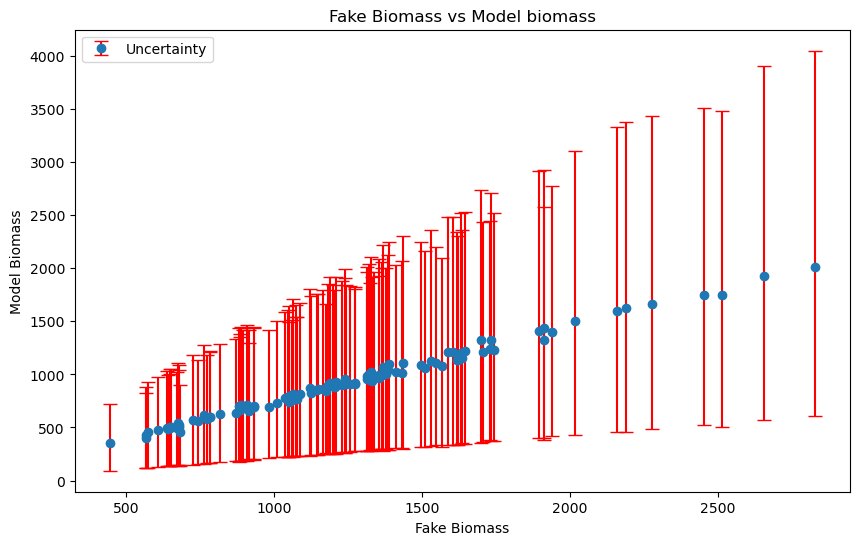

In [43]:
plt.figure(figsize=(10, 6))
plt.errorbar(df['Y_fake'], df['simulation_mean'], yerr=[df['simulation_mean'] - df['simulation_10'], df['simulation_90'] - df['simulation_mean']], fmt='o', ecolor='r', capsize=5, label='Uncertainty')
plt.xlabel('Fake Biomass')
plt.ylabel('Model Biomass')
plt.title('Fake Biomass vs Model biomass')
plt.legend()
